# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Connection to your drive

In [15]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Useful libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Sat Jan 20 19:39:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Managing data

### Load and uncompress the archive on Gdrive (rather than on your own desktop)
Uncomment the following line to do it.

In [ ]:
# !wget -P /content/gdrive/MyDrive/teaching/pizza/ http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip
# !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/'
# !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip.1' -d '/content/gdrive/MyDrive/teaching/pizza/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3918.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/4100.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/2272.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3432.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3840.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3395.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/0955.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/0527.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/0280.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/1367.png  
  inflating: /conte

### Read data

and build the train and test dataset

In [ ]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
x_all = np.arange(y_all.shape[0])

# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(y_train.shape)

y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

print(y_test.shape)


(3976, 10)
(497, 10)


### Display one sample image

0046.png


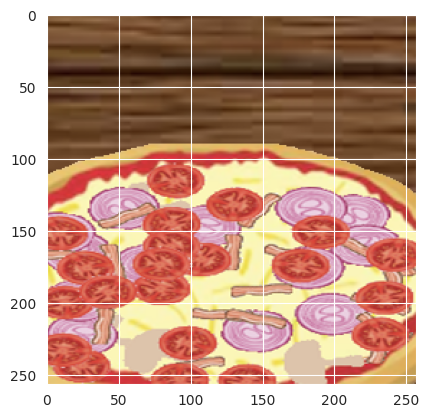

In [ ]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Store train images in memory

This should make learning faster.

In [ ]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

### Dataset class

In [ ]:
class myDataset(Dataset):
    """Pizza dataset"""

    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In [ ]:
batch_size = 25

input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img_data_train = img_all[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)


### Visualize data loader

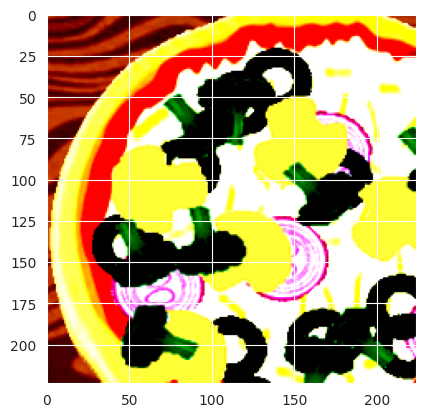

torch.Size([25, 3, 224, 224])


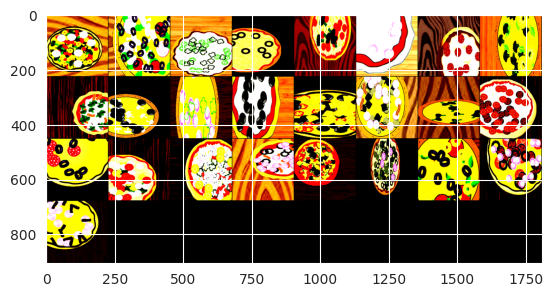

In [ ]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))


## Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


### Compute deep features for images

Example of how to compute deep image features. Here, we use a resnext network, but another may be as good and cheaper to compute and store.

In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat_resnext.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from ".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données
      img, targets = data
      # print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)



Loading image features from 


### Learning multi-label from pre-computed features

In [14]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat, y_all, test_size=0.2, random_state=123)

print(feat_train.shape)

# Cheсks if labels are the same as the image split
print(np.all(y_val == yfeat_val))

# Use your favorite multilabel predictor...




(3976, 2048)
True


### Simple network definition

An elementary convolutional network with input datasize of 32x32.

If you want to  use it, you will need to modify the dataloader.

In [16]:

# network class
class SimpleCNN(nn.Module):
# Network requires 32x32 input images
  def __init__(self, nlabel = 10):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel

    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)
    self.lin1 = nn.Linear(256, 128)
    self.lin2 = nn.Linear(128, self.nlabel)

  def forward(self, x):

    # 32x32

    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)

    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)

    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)

    # 4x4
    y0 = x3p.view(x3p.size(0), -1)

    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    y2 = self.lin2(y1r)

    return y2


### Another more complex network

From torchvision.

In [ ]:
nlabel = y_all.shape[1]

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel)

# Name of the network
tag = "efficientNet"

# network = SimpleCNN(nlabel = nlabel)
# # Name of the network
# tag = "simpleCNN"


## Learning

Generic function for multi-label learning.

You have to write it!!

In [ ]:
#from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

import copy

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):

    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses = []

    # iterate over epochs
    for epoch in range(num_epochs):
      print("Epoch {}".format(epoch))

      # Learning step

    return model, train_perf, test_perf, train_losses



### Example of a code calling the learning function

In [ ]:
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    print('Resume from last learning step')
    network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
#criterion = ...
#optimizer = ...
#scheduler = ...

# Learning

max_epoch = 20
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

network = learned_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)



### Final evaluation

An example of performance computation.

Again, the problem is multi-label prediction, not classification: performance metrics may be different (make a little search to find relevant ones).

In [ ]:
testloader = test_dataloader


# set the model to evaluation mode
network.eval()

# create the per
perf_label_test = np.zeros((1,nlabel))

# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)

        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        # compute the predictions
        pred = (outputs_np > 0)

        # update the performance
        perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

# Prints the performance (per label)

oa_test = perf_label_test / len(testloader.dataset)
print(oa_test)